In [101]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
import ast
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from collections import Counter
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from gower import gower_matrix, gower_dist
from utils import multiple_graphs

Считываем подготовленный датасет

In [102]:
df = pd.read_csv('Result_26_5.csv')
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,versions
0,6ce3b6b5-280f-4c81-9016-5ec7771202cb,0,RU,"['4f9d83d3-f99e-4f19-80cd-38ff133122ad', 'f3b4...","['mobile', 'mobile', 'mobile', 'mobile', 'mobi...",11963194,0,0,"['drama', 'youth', 'thriller', 'drama', 'youth...","['Молодые и дерзкие', 'Короткометражное кино',...","['Movie', 'Series', 'Series', 'Movie', 'Movie']","['2023-08-27 19:04:12', '2023-08-23 20:40:51',...","['2023-08-27 19:25:53', '2023-08-23 21:56:20',..."
1,a0d47245-6240-4b04-b189-6226b1569eb2,0,RU,['4f819e7c-6384-433e-9184-e793b8d7d82a'],['web'],9402,0,0,"['thriller', 'drama']","['Москва крупным планом', 'Интриги', 'Манипуля...",['Series'],['2024-05-31 17:22:26'],['2024-05-31 17:27:53']
2,18cde70f-00e0-422d-b1ea-57a639615255,0,RU,"['94f12d99-78bf-4785-9b8f-e6eb338abfe9', 'c0c4...","['tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv', 'tv...",503510604,0,0,"['melodrama', 'drama', 'comedy', 'family', 'me...","['Нездоровые отношения', 'Звездный актерский с...","['Movie', 'Series', 'Series', 'Series', 'Movie...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',...","['2025-04-27 13:29:52', '2025-04-07 10:16:27',..."
3,476fb1b6-8814-4c33-b154-bce5b7352bd6,1,RU,['1564d800-1fb2-452b-82ee-6b4c88672b9e'],['tv'],5948100,0,0,"['entertainment', 'education', 'talkshow']","['Суперхиты', 'Дружная семья', 'Про дружбу', '...",['Series'],['2023-08-20 11:27:41'],['2023-08-20 13:06:20']
4,70e5db19-435a-4125-b820-7181b4462548,0,DE,"['608da742-46c3-4a5d-8134-532fd391a456', '9eb1...","['mobile', 'mobile', 'tv', 'mobile', 'mobile',...",169830607,0,0,"['detective', 'drama', 'drama', 'comedy', 'dra...","['Ведется расследование', 'Мрачная атмосфера',...","['Series', 'Series', 'Series', 'Series', 'Movi...","['2024-01-20 17:55:21', '2024-01-07 09:58:57',...","['2024-01-20 19:42:06', '2024-01-07 10:34:05',..."


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_id        2012 non-null   object
 1   profile_is_child  2012 non-null   int64 
 2   geo               2012 non-null   object
 3   product_ids       2012 non-null   object
 4   device            2012 non-null   object
 5   delta             2012 non-null   int64 
 6   positive          2012 non-null   int64 
 7   negative          2012 non-null   int64 
 8   genres            2012 non-null   object
 9   hashtags          2012 non-null   object
 10  cls               2012 non-null   object
 11  starts            2012 non-null   object
 12  versions          2012 non-null   object
dtypes: int64(4), object(9)
memory usage: 204.5+ KB


## Подготовка данных
### 1. Подготовка числовых признаков

In [104]:
X = pd.DataFrame()
product_ids = df['product_ids'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df['views_count'] = product_ids.map(lambda x: len(x))
# Так как в числовых признаках большой разброс делаем нормализацию данных
scaler = MinMaxScaler()
cols = [
    'views_count', 
    'delta', 
    # 'positive',
    # 'negative'
]
X[cols] = scaler.fit_transform(df[cols])
X.head()

,views_count,delta
0,0.012658,1.187236e-03
1,0.000000,9.320695e-07
2,0.186709,4.996879e-02
3,0.000000,5.902931e-04
4,0.034810,1.685412e-02


### 2. Подготовка категориальных признаков

In [105]:
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
    
def data_binarize(series):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(series)
    return pd.DataFrame(encoded, columns=mlb.classes_)

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

classes = df['cls'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
classes_df = classes.apply(most_frequent)

devices = df['device'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
devices_df = devices.apply(most_frequent)

starts = df['starts'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

times_of_day = starts.apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
)
period_df = times_of_day.apply(most_frequent)

weekdays = starts.apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
)
weekdays_df = weekdays.apply(most_frequent)

genres = df['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

genres_df = genres.apply(most_frequent)

X = pd.concat([
    X,
    # df['profile_is_child'].fillna(0).astype(int),
    classes_df,
    # devices_df,
    # weekdays_df,
    period_df,
    genres_df
], axis=1)
X.head(100)

,views_count,delta,cls,starts,genres
0,0.012658,1.187236e-03,Movie,Evening,youth
1,0.000000,9.320695e-07,Series,Evening,various
2,0.186709,4.996879e-02,Series,Day,drama
3,0.000000,5.902931e-04,Series,Day,various
4,0.034810,1.685412e-02,Series,Evening,drama
...,...,...,...,...,...
95,0.053797,4.265851e-03,Series,Evening,drama
96,0.003165,1.157345e-03,Series,various,various
97,0.319620,1.134558e-01,Series,Evening,comedy
98,0.123418,8.847196e-03,Series,Evening,comedy


In [106]:
cats = list(range(2, len(X.columns)))
X_train = X.head(200)

n_clusters = []
s_scores =  []
ch_scores = []
costs = []

for k in range(5, 70):
    try:
        k_proto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_init=3, n_jobs=-1)
        clusters = k_proto.fit_predict(X_train, categorical=cats)
        Xg = gower_matrix(X_train)
        s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
        ch_scores.append(calinski_harabasz_score(Xg, clusters))
        
        costs.append(k_proto.cost_)
        n_clusters.append(k)
    except Exception as e:
        print(f'{e} Number of clusters {k}')
        break

Clustering algorithm could not initialize. Consider assigning the initial clusters manually. Number of clusters 39


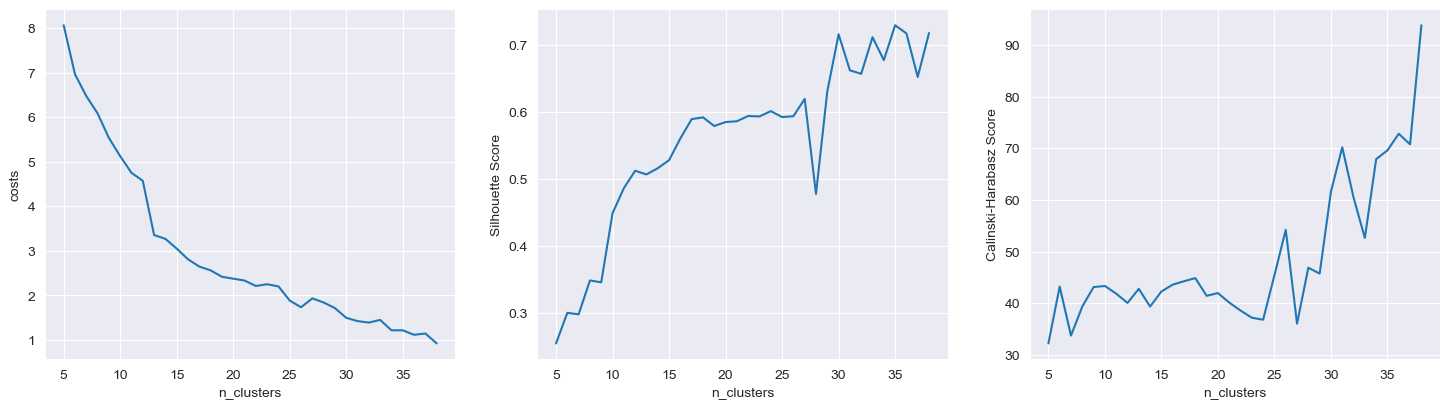

In [107]:
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(3, 'n_clusters', train_results)

In [108]:
k_proto = KPrototypes(n_clusters=15, init='Cao', random_state=42, n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=cats)
s_score = silhouette_score(gower_matrix(X), clusters, metric="precomputed")
ch_score = calinski_harabasz_score(gower_matrix(X), clusters)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.5843920111656189
Calinski-Harabasz Score: 438.3007763217631


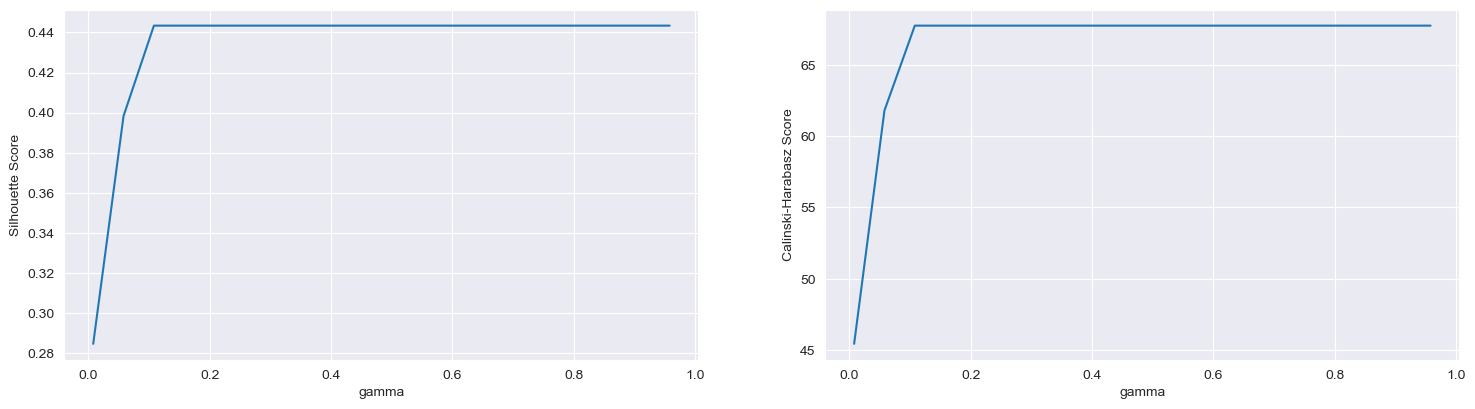

In [109]:
X_cross = X.head(300)
gammas = []
s_scores =  []
ch_scores = []
for gamma in np.arange(0.008,1, 0.05):
    k_proto = KPrototypes(n_clusters=10, init='Cao', random_state=42, n_jobs=-1, gamma=round(gamma, 2))
    clusters = k_proto.fit_predict(X_cross, categorical=cats)
    gammas.append(gamma)
    Xg = gower_matrix(X_cross)
    s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
    ch_scores.append(calinski_harabasz_score(Xg, clusters))
test_results = pd.DataFrame({'gamma':gammas, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(2, 'gamma', test_results)

In [110]:
k_proto = KPrototypes(n_clusters=60, init='Cao', random_state=42, n_jobs=-1, gamma=.14)
clusters = k_proto.fit_predict(X, categorical=cats)
gm = gower_matrix(X)
s_score = silhouette_score(gm, labels=k_proto.labels_, metric="precomputed")
ch_score = calinski_harabasz_score(gm, k_proto.labels_)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.7831703424453735
Calinski-Harabasz Score: 627.6272075088077


In [111]:
df['clusters'] = clusters
df.to_csv('results.csv')

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


<Axes: >

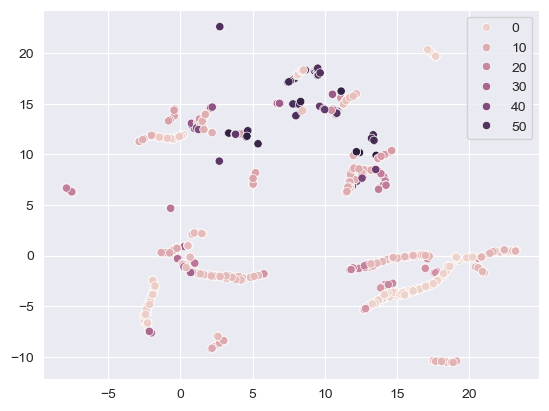

In [112]:
embedding = umap.UMAP(metric='precomputed').fit_transform(gm)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusters)